In [2]:
import json
import statistics
import numpy as np
import matplotlib.pyplot as plt
from scipy.spatial import distance
from scipy.cluster.hierarchy import linkage
from scipy.cluster.hierarchy import fcluster
from scipy.spatial.distance import pdist, squareform
import sklearn.cluster as cluster
import time
import scipy
import seaborn as sns
import random
sns.set_context('poster')
sns.set_color_codes()
plot_kwds = {'alpha': 0.25, 's':80, 'linewidths':0}

# set up type of service

In [3]:
# user input
user_input = 'Restaurants'
# u_id = 'McLqvYLBQoCFQikU9dC4cQ'

# read iin user file and generate valid user based on review count

In [4]:
# # read in user file
# user = {}
# with open('./user.json', 'r') as uf:
#     for line in uf:
#         l = json.loads(line)
#         key = l['user_id']
#         value = l['review_count']
#         user[key] = value
# # filter out valid user
# # thredhold define the number of review a user has
# def filter_user(user, thredhold):
#     tmp = sorted(user.items(), key=lambda x:-x[1])
#     listu = [x[0] for x in tmp if x[1] > thredhold]
#     new_user = {}
#     for i in listu:
#         new_user[i] = user[i]
#     return new_user

# valid_user = filter_user(user, 20)

# read in business file, compose business categories, business rating on category and business postal code dictionary

In [5]:
# initialize business data
bcmap = {}
with open('./business.json','r') as bf:
    for line in bf:
        l = json.loads(line)
        
        key = l['business_id']
        #Business Category Dictionary
        category = l['categories']
        bcmap[key] = category

# generate top categories
category = {}
for i in bcmap:
    if user_input in bcmap[i]:
        for j in bcmap[i]:
            if j not in category:
                category[j] = 1
            else:
                category[j] += 1
top_cate = sorted(category.items(), key=lambda x:(-x[1]))[1:21]
tc = []
for i in top_cate:
    tc.append(i[0])
    
# initialize business data   
location = {}
bcrmap = {}
business_name = {}
with open('./business.json','r') as bf:
    for line in bf:
        l = json.loads(line)
        key = l['business_id']
        category = l['categories']
        
        # Business City Dictionary
        city = l['city']
        location[key] = city
        
        # Business -> Category -> Star Dictionary
        stars = l['stars']
        valid = False
        number_of_tc = 0
        if key not in bcrmap:
            bcrmap[key] = {}
        for i in category:
            if i in tc:
                number_of_tc += 1
                valid = True
                bcrmap[key].setdefault(i,[]).append(stars)
        if not valid or number_of_tc <3:
            del bcrmap[key]
            
            
        # Business name -> Address Dictionary
        name = l['name'] +','  + l['address'] +','  + l['city'] +',' + l['state']
        business_name[key] = name
        

# read in review file and generate user to category to rating map

In [6]:
# initialize user review data
# User -> Categories -> Stars
ucrmap = {}
test_urcmap = {}
user_rating = {}
with open('./review.json', 'r') as rv:
    for line in rv:
        n1 = json.loads(line)
        okey = n1['user_id']
        year = n1['date']
        ikeys = bcmap[n1['business_id']]
        bid = n1['business_id']
        value = n1['stars']
        
        user_rating.setdefault(okey, []).append(value)
        
        if int(n1['date'].split('-')[0]) < 2016:
            if okey not in ucrmap:
                ucrmap[okey] = {}
            for ikey in ikeys:
                if ikey in tc:
                    ucrmap[okey].setdefault(ikey, []).append(value)
        else:
            if okey not in test_urcmap:
                test_urcmap[okey] = {}
            test_urcmap[okey][bid] = value

In [7]:
filter_user = {}
valid_user = {}
valid_test_user = {}
for i in user_rating:
    if len(user_rating[i]) >= 20:
        filter_user[i] = len(user_rating[i])
raw = sorted(filter_user.items(), key=lambda x:-x[1])
valid_list = []
for k, v in raw:
    if k in ucrmap and k in test_urcmap:
        valid_list.append(k)
        valid_user[k] = ucrmap[k]
        valid_test_user[k] = test_urcmap[k]

# transform rating to vector format

In [8]:
def generate_nbcrmap(data):
    bcrmap = data
    for business in bcrmap:
        for k, v in bcrmap[business].items():
            bcrmap[business][k] = statistics.mean(v)

    for business in bcrmap:
        for i in tc:
            if i not in bcrmap[business]:
                bcrmap[business][i] = 3

    nbcrmap = {}
    for k, v in bcrmap.items():
        nbcrmap[k] = []
        value = []
        for i in tc:
            value.append(v[i])
        nbcrmap[k] = value
    return nbcrmap

nbcrmp = generate_nbcrmap(bcrmap)

In [9]:
# Compose user category vector
def generate_nucrmap(data):
    ucrmap = data
    for user in ucrmap:
        for cate, value in ucrmap[user].items():
            ucrmap[user][cate] = statistics.mean(value)
    for user in ucrmap:
        for i in tc:
            if i not in ucrmap[user]:
                ucrmap[user][i] = 3

    nucrmap = {}
    for k, v in ucrmap.items():
        nucrmap[k] = []
        value = []
        for i in tc:
            value.append(v[i])
        nucrmap[k] = value
    return nucrmap

nucrmap = generate_nucrmap(valid_user)

In [39]:
data0 = {}
for i in valid_list[:1000]:
    data0[i] = nucrmap[i]
listV1 = list(data0.values())

data = {}

for i in valid_list[:5000]:
    data[i] = nucrmap[i]


In [40]:
listV = list(data.values())
listK = list(data.keys())


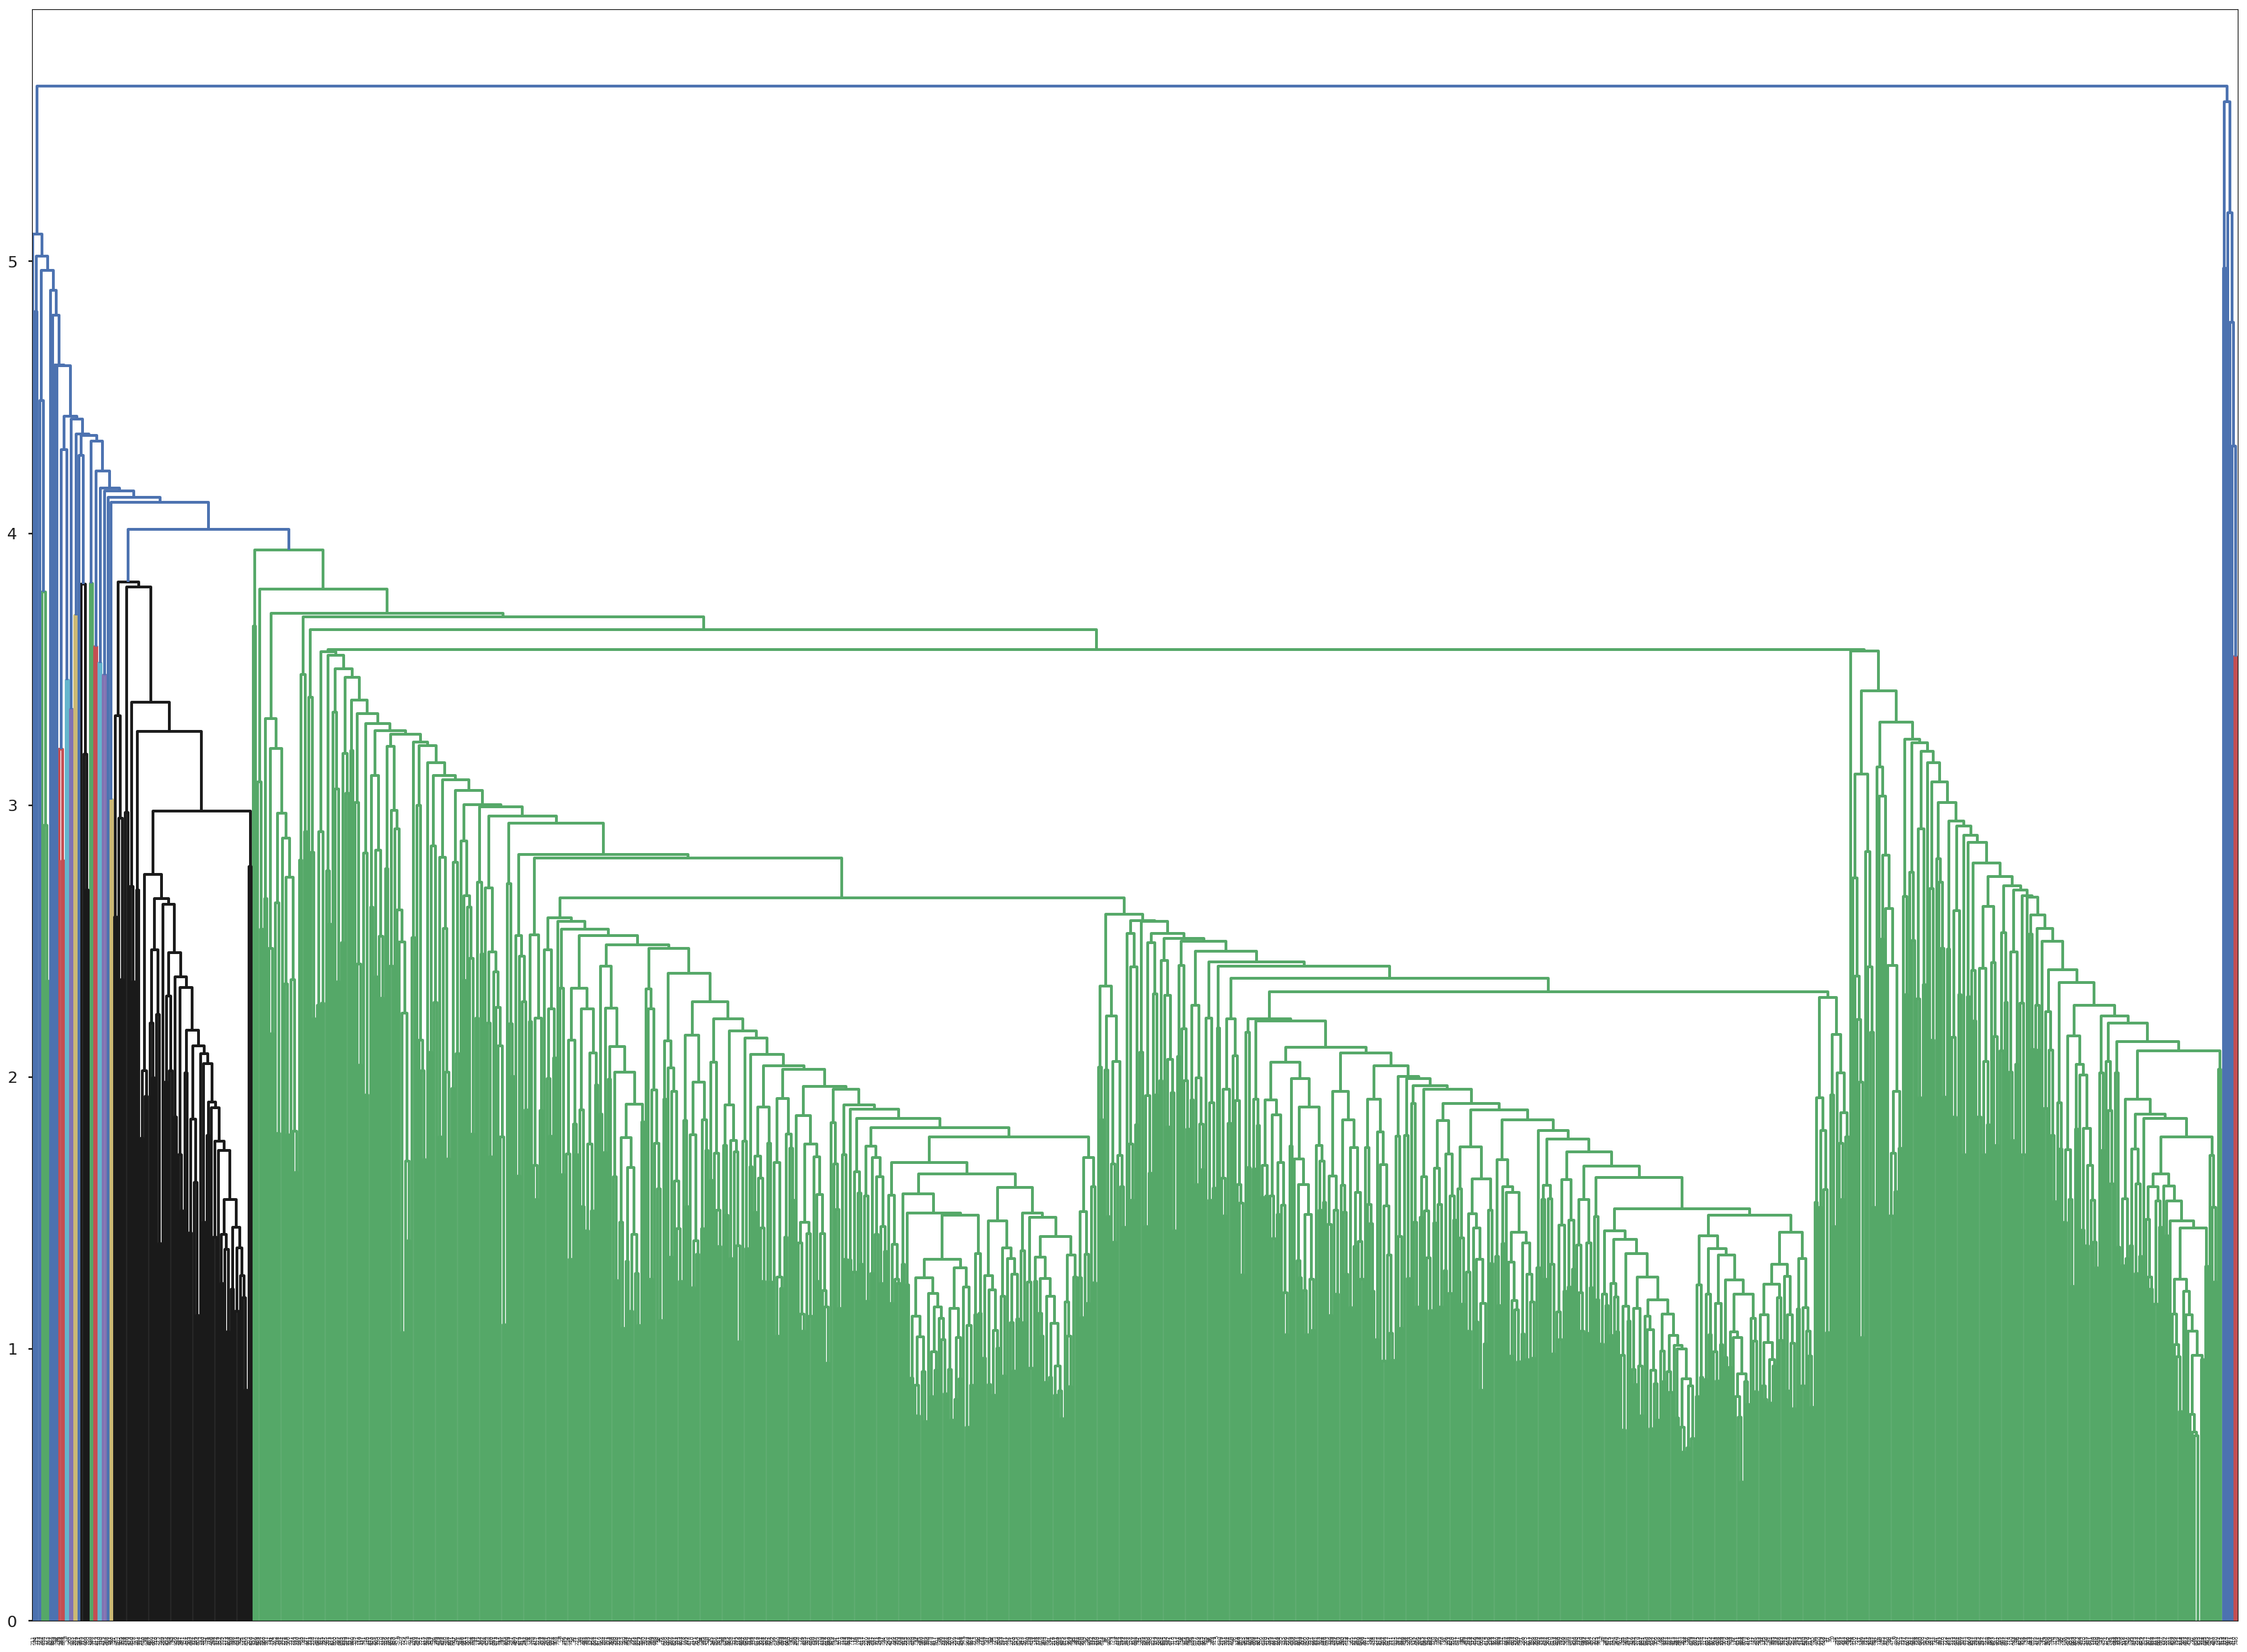

In [12]:
# Agglomerative clustering using scipy
Z = scipy.cluster.hierarchy.linkage(listV1, method='average')
plt.clf()
fig = plt.figure(figsize=(40, 30), dpi=100, facecolor='w', edgecolor='k')
dd = scipy.cluster.hierarchy.dendrogram(Z)
plt.savefig('{}.pdf'.format('average'))
plt.show()

# Use cophenetic correlation for evaluation 

In [13]:
c, coph_dists = scipy.cluster.hierarchy.cophenet(Z, pdist(listV))
print("c, coph_dists = cophenet(Z, pdist(X)); c is ideally close to one, c="+repr(c))

c, coph_dists = cophenet(Z, pdist(X)); c is ideally close to one, c=0.71285869697539972


size = 8000;   c, coph_dists = cophenet(Z, pdist(X)); c is ideally close to one, c=0.68441209386784496  
size = 5000;   c, coph_dists = cophenet(Z, pdist(X)); c is ideally close to one, c=0.69580000510359319  
size = 3000;   c, coph_dists = cophenet(Z, pdist(X)); c is ideally close to one, c=0.70658970892720374  
size = 2000;   c, coph_dists = cophenet(Z, pdist(X)); c is ideally close to one, c=0.73391695357663456  
size = 1000;   c, coph_dists = cophenet(Z, pdist(X)); c is ideally close to one, c=0.73100111995588535  
size = 500;    c, coph_dists = cophenet(Z, pdist(X)); c is ideally close to one, c=0.73846506222107178  
size = 100;    c, coph_dists = cophenet(Z, pdist(X)); c is ideally close to one, c=0.83762182127852514  
size = 50;     c, coph_dists = cophenet(Z, pdist(X)); c is ideally close to one, c=0.87879134020736049  
size = 10;     c, coph_dists = cophenet(Z, pdist(X)); c is ideally close to one, c=0.91836580287816971  
size = 3;      c, coph_dists = cophenet(Z, pdist(X)); c is ideally close to one, c=0.55192082653918684  

In [41]:
#agglomerative clustering using sklearn 
data1 = []
for k,v in nucrmap.items():
    data1.append(v)
np.save('123', np.array(data1))
data1 = np.load('123.npy')

In [42]:
# get number of clusters from above plot and generate clusters dictionary
model = cluster.AgglomerativeClustering(linkage='average', n_clusters=11)
result = model.fit_predict(listV)
clusters = {}
for i in range(len(result)):
    k = result[i]
    v = data1[i]
    clusters.setdefault(k, []).append(v)

In [43]:
# user index corresponding to user vector dictionary
index = random.randint(0,len(listK)-1)

In [44]:
# Average Vector for each cluster generated above

average_vector = {}
for i in list(clusters.keys()):
    average_vector[i] = np.mean(clusters[i], axis=0)
    

In [45]:
# Get the users cluster vector 
user_vector = average_vector[result[index]]

In [46]:
# Perfor inner dot product between user_vector and each business vector

result_bcrmap = {}
for i in nbcrmp:
    result_bcrmap[i] = np.inner(user_vector, nbcrmp[i])

In [47]:
# Sort the business based on the minimum value of above operation. Keep top 20 businesses
top_business = sorted(result_bcrmap.items(), key=lambda x:(-x[1]))[1:20]

In [48]:
# print out the recommended businesses

for k,v in top_business:
    print(business_name[k])

Milk + Honey JCC,12701 N Scottsdale Rd,Scottsdale,AZ
Johnny Vegas Grill,3342 S Sandhill Rd,Las Vegas,NV
Bar Sixty,60 Bathurst Street,Toronto,ON
Deux - Cave à Manger,2 Rue Turgeon,Sainte-Therese,QC
Merchant Street,2391 W 11th St,Cleveland,OH
Four Peaks Brewing,1340 E 8th St, Ste 104,Tempe,AZ
Sugar Jam Bake Shop & Bistro,7950 E Redfield Rd,Scottsdale,AZ
Paint Cabin,723 Gerrard Street E,Toronto,ON
The Original Marketplace,7272 E Indian School Rd, Ste 105,Scottsdale,AZ
Panini Bread and Grill,4129 E Van Buren St, Ste 105,Phoenix,AZ
MoTo Coffee and Snack Bar,1321 Dundas Street W,Toronto,ON
DaBuzis,3547 Washington Ave,Finleyville,PA
3 Brothers Pizza,7523 Pearl Rd,Middleburg Heights,OH
Sorso Wine Room,15323 N Scottsdale Rd, Ste 150,Scottsdale,AZ
Local Jonny's,6033 E Cave Creek Rd,Cave Creek,AZ
Presidio Cocina Mexicana,519 W Thomas Rd,Phoenix,AZ
Cocothe,545 Beaver St,Sewickley,PA
B&R Wine - Food,7366 E Shea Blvd, Ste 112,Scottsdale,AZ
Phoenix City Grille,5816 N 16th St,Phoenix,AZ


In [80]:
def generate_recommendatioin(uid):
    index = listK.index(uid)
    uvector = average_vector[result[index]]
    r = {}
    for i in nbcrmp:
        r[i] = np.inner(uvector, nbcrmp[i])
    top_business = sorted(r.items(), key=lambda x:(-x[1]))[1:100]
    return [k for k,v in top_business]

In [81]:
def cacluate_hr(uid, bids):
    score = 0
    count = 0
    for bid in bids:
        if bid in valid_test_user[uid]:
            count += 1
            if valid_test_user[uid][bid] > 3:
                score += 1
            elif valid_test_user[uid][bid] < 2:
                score -= 1
    return np.array([score, count])

In [82]:
# def calculate_ndcg(uid, bids):
#     gain = 0
#     ind_list = []
#     for i in range(len(bids)):
#         bid = bids[i]
#         if bid in valid_test_user[uid]:
#             ind_list.append(i+1)
#             gain += valid_test_user[uid][bid]/(i+1)
#     idcg = 0
#     for i in ind_list:
#         idcg += 5/i
#     if idcg == 0:
#         return 0
#     return gain/idcg

In [85]:
def evaluate(list_test):
    hr = np.array([0,0])
    ndcg = 0
    for uid in list_test:
        recs = generate_recommendatioin(uid)
        tmp = cacluate_hr(uid, recs)
#         ndcg += calculate_ndcg(uid, recs)
        hr += tmp
    print(hr[0]/hr[1])

In [87]:
for i in [10, 100, 1000]: 
    evaluate(valid_list[:i])

0.736842105263
0.741379310345
0.756218905473
